In [12]:
import datetime
import ee
import geopandas as gp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn.preprocessing

from dateutil.relativedelta import relativedelta
from dateutil.relativedelta import relativedelta
from scipy import stats

ee.Initialize()

In [24]:
def init():
    
    '''
    Set the init params:
    1) Area
    2) Satellite 
    3) Years to analyze 
    
    '''
    
    ##### AREA #####

    # County 
    area = (ee.FeatureCollection('ft:1FEPBzXYqUbdWXG2wTFOyb-ts9_GbeI5NFraMq2yk').filter(ee.Filter().eq('COUNTY num', 95)))
    
    # Central Valley
    area = ee.FeatureCollection('ft:1h46ENpEp8vO3pOe1EqeF1sZLEDhSVMxbu8pHAoU4', 'geometry')
        
    # Whole state:
    area = (ee.FeatureCollection('ft:1fRY18cjsHzDgGiJiS2nnpUU3v9JPDc2HNaR7Xk8').filter(ee.Filter().eq('Name', 'California')))
    
    # HUC 4s draining to the CV 
    cv = gp.read_file("../shape/cv_hu6.shp")
    lls = cv.geometry.iloc[0]
    x,y = lls.exterior.coords.xy
    coords = [list(zip(x,y))]
    
    area = ee.Geometry.Polygon(coords)
        
    ###### SATELLITES ######
    
    prism = ee.ImageCollection("OREGONSTATE/PRISM/AN81m")
    gridmet = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE')
    
    ##### TIME RANGE #####
    years = [x for x in range(1980, 2016)]
    
    return [[prism, gridmet],area,years]
    
def retrieve(satellite):
    if satellite == ee.ImageCollection('TRMM/3B42'):
        var = "precipitation"
    if satellite == ee.ImageCollection('TRMM/3B43V7'):
        var = "precipitation"
    if satellite == ee.ImageCollection("OREGONSTATE/PRISM/AN81m"):
        var = "ppt"
    if satellite == ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD'):
        var = "precipitation"
    if satellite == ee.ImageCollection('MODIS/006/MOD16A2'):
        var = "ET"
    elif satellite == ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H'):
        var = "Evap_tavg"
    elif satellite == ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE'):
        var = "aet"
    return var

In [25]:
def filter_date(product,year):
    startyear = ee.Date.fromYMD(year,1,1)
    endyear =ee.Date.fromYMD(year+1,1,1)
    prod = product.filterDate(startyear, endyear).sort('system:time_start', False).select(retrieve(product))
    return prod
    
def aggregate_product(product,year):
    
    # Select appropriate resolution from product. Set lower if you exceed the google request
    if product == ee.ImageCollection('MODIS/006/MOD16A2'):
        res = 2500
    elif product == ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H'):
        res = 12500
    elif product == ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE'):
        res = 4000
    if product == ee.ImageCollection('TRMM/3B42'):
        res = 12500
    elif product == ee.ImageCollection('TRMM/3B43V7'):
        res = 12500
    elif product == ee.ImageCollection("OREGONSTATE/PRISM/AN81m"):
        res = 3200
    elif product == ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD'):
        res = 5500
    
    # Filter
    filtered = filter_date(product, year)

    # calculate the monthly mean
    def calc_sum(imageCollection,year):
        mylist = ee.List([])
        months = range(1,13)
        for m in months:
                w = imageCollection.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).sum();
                mylist = mylist.add(w.set('year', year).set('month', m).set('date', ee.Date.fromYMD(year,m,1)).set('system:time_start',ee.Date.fromYMD(year,m,1)))
        return ee.ImageCollection.fromImages(mylist)

    # run the calcMonthlyMean function
    monthly = ee.ImageCollection(calc_sum(filtered, year))

    # select the region of interest, res is the cellsize in meters
    monthly = monthly.getRegion(area,res,"epsg:4326").getInfo()

    return monthly 

def df_from_ee_object(imcol):
    df = pd.DataFrame(imcol, columns = imcol[0])
    df = df[1:]
    return(df)

def array_from_df(df, variable, month):
    df = df[df.id == str(month)] 
    
    # get data from df as arrays
    lons = np.array(df.longitude)
    lats = np.array(df.latitude)
    data = np.array(df[variable]) # Set var here 
                                              
    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)

    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)    
    nrows = len(uniqueLats)

    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0] 
    xs = uniqueLons[1] - uniqueLons[0]

    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32)

    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner
    
    return arr

In [26]:
def main(years, product):
    finals = []
    for year in years:
        finals.append(aggregate_product(product,year))
    
    dfs = []
    for i in finals:
        dfs.append(df_from_ee_object(i))
    
    months = [int(x) for x in dfs[0].id.unique()]
    
    yearly = []
    for i in dfs:
        result = []
        for m in months:
            monthly = []
            a = array_from_df(i,retrieve(product),m)
            result.append(a)
        yearly.append(result)
        
    yearly_arrays = [np.array(x) for x in yearly]
    timeseries = [np.array(x) for x in yearly_arrays]
    all_data = [item for sublist in timeseries for item in sublist]
    final = np.dstack(all_data)
    final = np.ma.masked_where(final == 0, final)
    
#   dist = final[np.logical_not(np.isnan(final))]
    
    return final

In [27]:
sats, area, years = init()

In [28]:
prism = main(years, sats[0])
gridmet = main(years, sats[1])

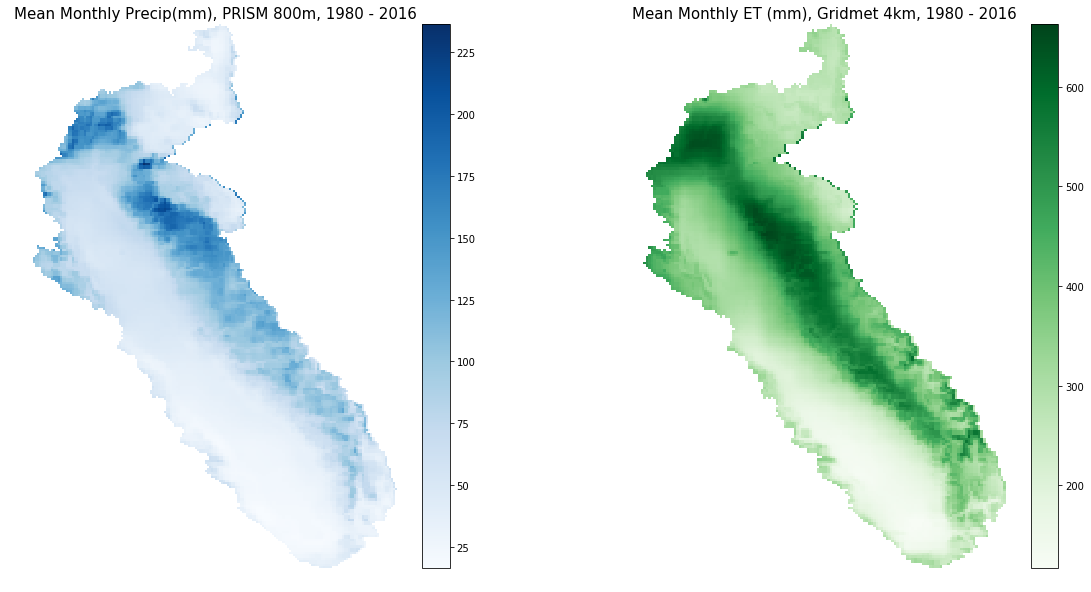

In [43]:
f = plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(np.mean(prism, axis = 2),cmap = plt.get_cmap("Blues")) 
plt.colorbar()
# plt.colorbar(orientation='horizontal')
plt.title("Mean Monthly Precip(mm), PRISM 800m, 1980 - 2016", size = 15)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(np.mean(gridmet, axis = 2),cmap = plt.get_cmap("Greens"))
plt.title("Mean Monthly ET (mm), Gridmet 4km, 1980 - 2016", size = 15)
# plt.colorbar(orientation='horizontal')
plt.colorbar()
plt.axis('off')

plt.show()


In [34]:
def calc_spatial_trend(array):

    t = array.copy()

    x_array = np.arange(t.shape[2]) # time dimension

    slopes = []

    for i in range(0, t.shape[0]):
        for j in range(0, t.shape[1]):
            y_array = t[i,j,:]
            slope, intercept, r_value, p_value, std_err = stats.linregress(x_array,y_array)
            slopes.append(slope)
                
    s = np.array(slopes)
    s = s.reshape(t.shape[0],t.shape[1])
    s[s == 0 ] = np.nan
    
    return s

In [35]:
st_1 = calc_spatial_trend(prism)
st_2 = calc_spatial_trend(gridmet)

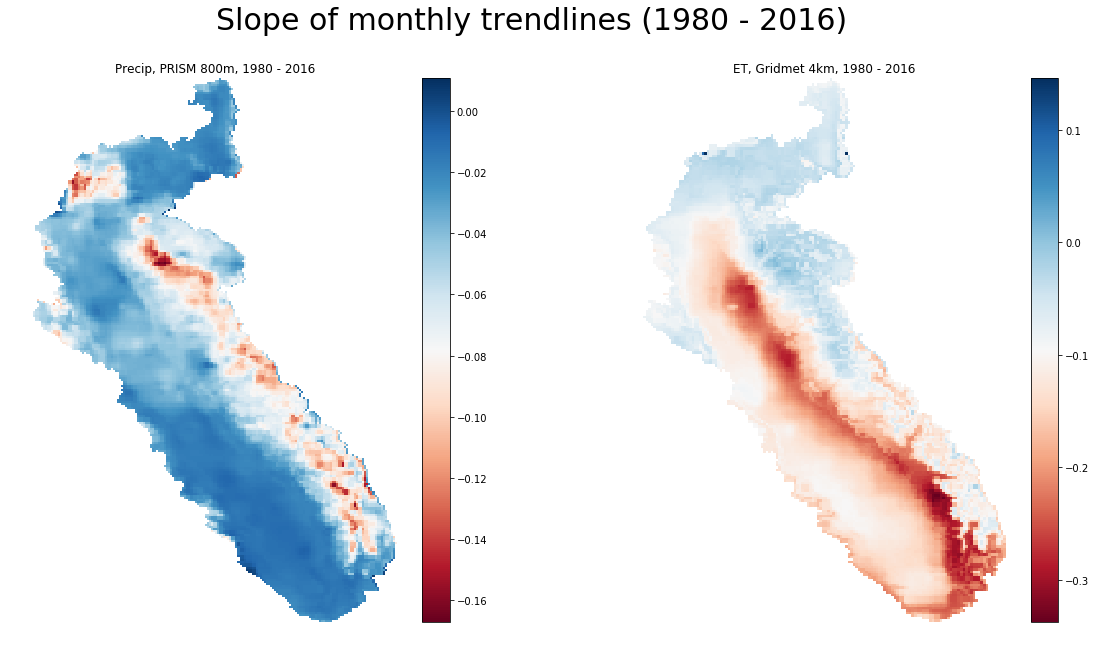

In [39]:
f = plt.figure(figsize=(20,10))

plt.suptitle("Slope of monthly trendlines (1980 - 2016)", size = 30)

plt.subplot(1,2,1)
plt.imshow(st_1,cmap = plt.get_cmap("RdBu"))
plt.colorbar()
plt.title("Precip, PRISM 800m, 1980 - 2016")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(st_2,cmap = plt.get_cmap("RdBu"))
plt.title("ET, Gridmet 4km, 1980 - 2016")
plt.colorbar()
plt.axis('off')

plt.show()

In [44]:
def get_monthly_sum(array):
    arr = array.copy()
    
    totals = []
    for i in range(0,array.shape[2]):
        total = np.nanmean(array[:,:,i]) * array.shape[0] *array.shape[2]
        totals.append(total)
        
    return np.array(totals)

In [45]:
p_sums = get_monthly_sum(prism)
g_sums = get_monthly_sum(gridmet)

In [ ]:
dates = [datetime.date(1980, 1, 1) + relativedelta(months=x) for x in range(0, 432)]

plt.figure(figsize=(10,5))
plt.title("Monthly ET / P sums(mm) timeseries")
plt.plot(dates,p_sums, label = "prism")
plt.plot(dates,p_sums, label = "gridmet")
plt.ylabel("precipitation (mm)")
plt.xlabel("Date")
plt.legend()

plt.savefig("../figs/monthly_timeseries.png")

plt.show()

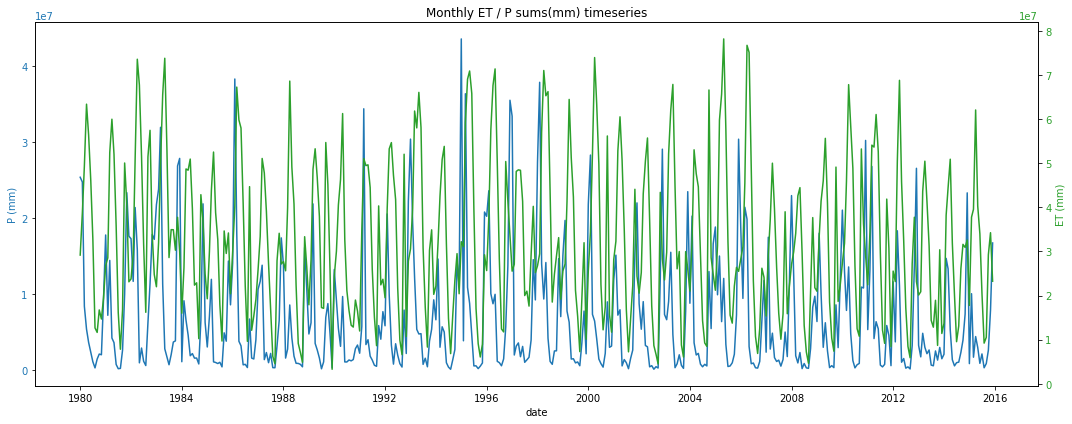

In [50]:
dates = [datetime.date(1980, 1, 1) + relativedelta(months=x) for x in range(0, 432)]

fig, ax1 = plt.subplots(figsize=(15,6))

plt.title("Monthly ET / P sums(mm) timeseries")

color = 'tab:blue'
ax1.set_xlabel('date')
ax1.set_ylabel("P (mm)", color=color)
ax1.plot(dates, p_sums, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('ET (mm)', color=color)  
ax2.plot(dates,g_sums,color = color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 

plt.show()

(array([ 1.,  1.,  3.,  3.,  8.,  7., 14., 10., 15., 18., 22., 27., 39.,
        53., 46., 37., 34., 49., 28., 17.]),
 array([15.00823671, 15.16653473, 15.32483274, 15.48313076, 15.64142878,
        15.79972679, 15.95802481, 16.11632283, 16.27462085, 16.43291886,
        16.59121688, 16.7495149 , 16.90781292, 17.06611093, 17.22440895,
        17.38270697, 17.54100498, 17.699303  , 17.85760102, 18.01589904,
        18.17419705]),
 <a list of 20 Patch objects>)

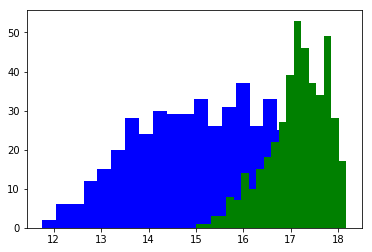

In [59]:
plt.hist(np.log(p_sums), bins = 20, color = "blue")
plt.hist(np.log(g_sums), bins = 20, color = "green")

In [60]:
outdf = pd.DataFrame(
    {'gridmet': g_sums,
     'prism': p_sums,
    })

outdf.index = dates

In [62]:
outdf.head()

,gridmet,prism
1980-01-01,2.917595e+07,2.535676e+07
1980-02-01,3.870969e+07,2.472921e+07
1980-03-01,4.932931e+07,8.405792e+06
1980-04-01,6.336753e+07,5.394146e+06
1980-05-01,5.640832e+07,3.663737e+06


In [75]:
# Read in the storage CSVs from the data folder

# find files
data_dir = "../data"
ds_file = [os.path.join(data_dir,x) for x in os.listdir("../data") if "storage" in x][0]
ds = pd.read_csv(ds_file, sep='\t', header=0)

q_file = [os.path.join(data_dir,x) for x in os.listdir("../data") if "Qs" in x][0]
q = pd.read_csv(qs_file)


In [76]:
ds.set_index(ds['dt'], inplace = True)
q.set_index(q.columns[0], inplace = True)

# convert to datetime
ds.index = pd.to_datetime(ds.index)

In [77]:
# convert to datetime
ds.index = pd.to_datetime(ds.index)
q.index = pd.to_datetime(q.index)

# Change the ds index to be beginning of the month
ds.index += datetime.timedelta(days = 1)


In [96]:
outdf.head(), ds.head(), q.head()

(                 gridmet         prism
 1980-01-01  2.917595e+07  2.535676e+07
 1980-02-01  3.870969e+07  2.472921e+07
 1980-03-01  4.932931e+07  8.405792e+06
 1980-04-01  6.336753e+07  5.394146e+06
 1980-05-01  5.640832e+07  3.663737e+06,
                               dt            s     region
 dt                                                      
 1973-11-01  1973-10-31T00:00:00Z  4575.555111  Entire CV
 1973-12-01  1973-11-30T00:00:00Z  4578.075790  Entire CV
 1974-01-01  1973-12-31T00:00:00Z  4581.297108  Entire CV
 1974-02-01  1974-01-31T00:00:00Z  4585.170011  Entire CV
 1974-03-01  1974-02-28T00:00:00Z  4588.180232  Entire CV,
             discharge_cms
 Unnamed: 0               
 1980-01-01     1095.86016
 1980-01-02     1197.80064
 1980-01-03     1200.63232
 1980-01-04     1152.49376
 1980-01-05     1067.54336)

In [97]:
# Merge the dfs
merged1 = pd.merge(outdf,q, left_index=True, right_index=True)
merged1.head()

,gridmet,prism,discharge_cms
1980-01-01,2.917595e+07,2.535676e+07,1095.86016
1980-02-01,3.870969e+07,2.472921e+07,1268.59264
1980-03-01,4.932931e+07,8.405792e+06,2030.31456
1980-04-01,6.336753e+07,5.394146e+06,832.51392
1980-05-01,5.640832e+07,3.663737e+06,458.73216


In [98]:
# Set the timezones to none
merged2 = merged1.tz_localize(None).copy()
ds = ds.tz_localize(None).copy()

# Merge again
df = pd.merge(merged2, ds, left_index=True, right_index=True)

# Drop irrelevant columns
df.drop(["region", 'dt'], axis = 1, inplace = True)

In [99]:
df.head()

,gridmet,prism,discharge_cms,s
1980-01-01,2.917595e+07,2.535676e+07,1095.86016,4586.674670
1980-02-01,3.870969e+07,2.472921e+07,1268.59264,4588.686787
1980-03-01,4.932931e+07,8.405792e+06,2030.31456,4590.926975
1980-04-01,6.336753e+07,5.394146e+06,832.51392,4592.742504
1980-05-01,5.640832e+07,3.663737e+06,458.73216,4593.733395


In [100]:
# Get the area over which precip and ET were calculated over
hu4 = gp.read_file("../shape/cv_hu6.shp")
study_area = hu4.AreaSqKm.values
study_area = study_area * 1000000. # sq km to sq m

# Now convert to the appropriate units

df['q'] = df.discharge_cms*2.628e+6 # convert cms to cubic m/month
df['p'] = df.prism*study_area * 1e-3 # multiply by study area and convert mm to m
df['et'] = df.gridmet*study_area * 1e-3 # multiply by study area and convert mm to m
df['s_m3'] = df.s * 1.23348e+9 # convert from million acre ft to cubic m 

In [101]:
df.head()

,gridmet,prism,discharge_cms,s,q,p,et,s_m3
1980-01-01,2.917595e+07,2.535676e+07,1095.86016,4586.674670,2.879921e+09,1.077600e+15,1.239906e+15,5.657571e+12
1980-02-01,3.870969e+07,2.472921e+07,1268.59264,4588.686787,3.333861e+09,1.050930e+15,1.645066e+15,5.660053e+12
1980-03-01,4.932931e+07,8.405792e+06,2030.31456,4590.926975,5.335667e+09,3.572254e+14,2.096374e+15,5.662817e+12
1980-04-01,6.336753e+07,5.394146e+06,832.51392,4592.742504,2.187847e+09,2.292379e+14,2.692963e+15,5.665056e+12
1980-05-01,5.640832e+07,3.663737e+06,458.73216,4593.733395,1.205548e+09,1.556998e+14,2.397214e+15,5.666278e+12


In [103]:
df['ds'] = df.p - df.et - df.q

In [105]:
# Compute annual ds sums from ds = P - ET - Q:

years = np.arange(df.index[0].year, df.index[-1].year+1)

sums = {}

for year in years:
    ds = df[df.index.year == year]
    ds_year = np.sum(ds['et'])
    sums[year] = ds_year
    

In [106]:
dt_idx = pd.date_range(start=df.index[0], end=df.index[-1] + relativedelta(years=1),  freq='Y')
ds_df = pd.DataFrame(sums.values(), index = dt_idx)
ds_df.columns = ["ds"]
ds_df['ds'] = sums.values()

ds_df.head()

,ds
1980-12-31,1.661789e+16
1981-12-31,1.742938e+16
1982-12-31,2.177617e+16
1983-12-31,2.093669e+16
1984-12-31,1.657490e+16


In [121]:
window = 3
ds_df['smoothed'] = ds_df['ds'].rolling(window, win_type='triang').mean()

In [122]:
ds_df.head()

,ds,smoothed
1980-12-31,1.661789e+16,NaN
1981-12-31,1.742938e+16,NaN
1982-12-31,2.177617e+16,1.831320e+16
1983-12-31,2.093669e+16,2.047960e+16
1984-12-31,1.657490e+16,2.005611e+16


In [123]:
mms = sklearn.preprocessing.MinMaxScaler()

scaled = []

for i in [ds_df['ds'],ds_df['smoothed'],df['s_m3']]:
    i = i[~np.isnan(i)]
    j = np.array(i).reshape(-1,1)
    out = mms.fit_transform(j)
    scaled.append(out)


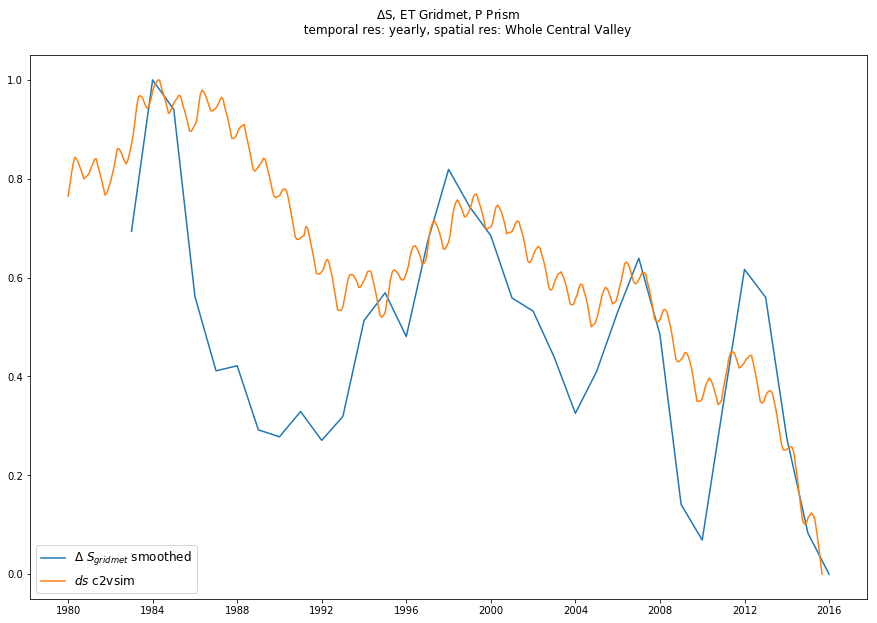

In [125]:
plt.figure(figsize=(15,10))

plt.title("""$\Delta$S, ET Gridmet, P Prism
          temporal res: yearly, spatial res: Whole Central Valley
          """)

# plt.plot(ds_df.index, scaled[0], label = "$\Delta$ $S_{gm} = P - ET_{gridmet} - Q_s$")
plt.plot(ds_df.index[window-1:], scaled[1], label = '$\Delta$ $S_{gridmet}$ smoothed')

plt.plot(df.index, scaled[2], label = "$ds$ c2vsim")

plt.legend(loc="lower left", fontsize = 'large')

plt.show()